 >balaji maharaj

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

In [2]:
# 1. Configuration Manager
def get_model_params(dataset_id):
    """Returns optimized hyperparameters based on dataset complexity."""
    # Common base parameters
    base_params = {
        'n_estimators': 250,
        'learning_rate': 0.03,
        'subsample': 0.8,
        'colsample_bytree': 0.7,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Dataset-specific overrides
    if dataset_id in ['FD002', 'FD004']:
        # High complexity (6 regimes) needs more regularization
        base_params.update({'max_depth': 4, 'reg_alpha': 10, 'min_child_weight': 5})
    else:
        # Lower complexity (1 regime) can handle more depth
        base_params.update({'max_depth': 6, 'reg_alpha': 1, 'min_child_weight': 1})
        
    return base_params

Python results
Dataset  RMSE  NASA Score
  FD001 39.21     8385.78
  FD002 38.42   110945.37
  FD003 34.74     3403.58
  FD004 44.86   113601.95



Notebook results
--- FINAL PROJECT SUMMARY ---
  Dataset   RMSE  NASA Score
0   FD001  19.62     1288.08
1   FD002  26.91     9606.78
2   FD003  21.13     1985.80
3   FD004  29.55    12727.74

In [ ]:
# 2. Data Loader _ v1
# def load_and_prep_data(dataset_id, data_dir="data/final_processed"):
#     """Loads training, testing, and ground truth files."""
#     train_path = os.path.join(data_dir, f"train_{dataset_id}_final.csv")
#     test_path = os.path.join(data_dir, f"test_{dataset_id}_final.csv")
#     truth_path = os.path.join(data_dir, f"RUL_{dataset_id}.csv")
    
#     df_train = pd.read_csv(train_path)
#     df_test = pd.read_csv(test_path)
#     y_truth = pd.read_csv(truth_path, header=None).values.flatten()
    
#     # Define features to drop (IDs and Targets)
#     drop_cols = ['unit_id', 'time', 'RUL', 'RUL_clipped', 'time', 'regime']
#     features = [c for c in df_train.columns if c not in drop_cols]
    
#     return df_train, df_test, y_truth, features

In [9]:
def load_and_prep_data(dataset_id):
    """
    Loads data with intelligent routing:
    - FD002/004 Train -> 'data/final_processed_v2' (150-cycle clip)
    - FD001/003 Train -> 'data/final_processed'    (125-cycle clip)
    - All Test/Truth  -> 'data/final_processed'    (Common source)
    """
    # 1. Define Directories
    common_dir = "data/final_processed"
    
    if dataset_id in ['FD002', 'FD004']:
        train_dir = "data/final_processed_v2"
        print(f"   ⚡ Using Enhanced Target (150-clip) for {dataset_id}")
    else:
        train_dir = common_dir
        print(f"   🔹 Using Standard Target (125-clip) for {dataset_id}")

    # 2. Construct Paths
    train_path = os.path.join(train_dir, f"train_{dataset_id}_final.csv")
    test_path = os.path.join(common_dir, f"test_{dataset_id}_final.csv")
    truth_path = os.path.join(common_dir, f"RUL_{dataset_id}.csv")
    
    # 3. Load Files
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Missing training file: {train_path}. Did you run the v2 notebook?")
        
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    y_truth = pd.read_csv(truth_path, header=None).values.flatten()
    
    # 4. Feature Selection
    # Dropping IDs, Targets, Time, and Regime (if present)
    drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
    features = [c for c in df_train.columns if c not in drop_cols]
    
    return df_train, df_test, y_truth, features

In [4]:
# 3. NASA Scoring Function
def compute_nasa_score(y_true, y_pred):
    """Calculates the exponential asymmetric NASA error score."""
    d = y_pred - y_true
    score = 0
    for diff in d:
        if diff < 0:
            score += np.exp(-diff / 13) - 1
        else:
            score += np.exp(diff / 10) - 1
    return score

In [5]:
# 4. The Workhorse Pipeline
def run_dataset_pipeline(dataset_id):
    """Orchestrates training and evaluation for a single dataset."""
    print(f"\n🚀 Processing {dataset_id}...")
    
    # Load Data
    df_train, df_test, y_truth, features = load_and_prep_data(dataset_id)
    
    # Train Model
    params = get_model_params(dataset_id)
    model = xgb.XGBRegressor(**params)
    model.fit(df_train[features], df_train['RUL_clipped'])
    
    # Predict on Test (Last Cycle Only)
    df_test_last = df_test.groupby('unit_id').last().reset_index()
    y_pred = np.maximum(model.predict(df_test_last[features]), 0)
    
    # Calculate Metrics
    rmse = np.sqrt(mean_squared_error(y_truth, y_pred))
    score = compute_nasa_score(y_truth, y_pred)
    
    return {
        'id': dataset_id,
        'rmse': rmse,
        'nasa_score': score,
        'y_truth': y_truth,
        'y_pred': y_pred
    }

In [10]:
# List of datasets to process
datasets = ['FD001', 'FD002', 'FD003', 'FD004']
all_results = []

for ds in datasets:
    res = run_dataset_pipeline(ds)
    all_results.append(res)
    print(f"   ✅ {ds} Complete | RMSE: {res['rmse']:.2f} | Score: {res['nasa_score']:.2f}")

# Convert to summary table
summary_df = pd.DataFrame([{
    'Dataset': r['id'], 
    'RMSE': round(r['rmse'], 2), 
    'NASA Score': round(r['nasa_score'], 2)
} for r in all_results])

print("\n--- FINAL PROJECT SUMMARY ---")
print(summary_df)


🚀 Processing FD001...
   🔹 Using Standard Target (125-clip) for FD001
   ✅ FD001 Complete | RMSE: 19.62 | Score: 1288.08

🚀 Processing FD002...
   ⚡ Using Enhanced Target (150-clip) for FD002
   ✅ FD002 Complete | RMSE: 26.91 | Score: 9606.78

🚀 Processing FD003...
   🔹 Using Standard Target (125-clip) for FD003
   ✅ FD003 Complete | RMSE: 21.13 | Score: 1985.80

🚀 Processing FD004...
   ⚡ Using Enhanced Target (150-clip) for FD004
   ✅ FD004 Complete | RMSE: 29.55 | Score: 12727.74

--- FINAL PROJECT SUMMARY ---
  Dataset   RMSE  NASA Score
0   FD001  19.62     1288.08
1   FD002  26.91     9606.78
2   FD003  21.13     1985.80
3   FD004  29.55    12727.74


In [11]:
def visualize_all_results(all_results):
    """Generates a 2x2 grid comparing True vs Predicted RUL for all datasets."""
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    for i, res in enumerate(all_results):
        ax = axes[i]
        y_true = res['y_truth']
        y_pred = res['y_pred']
        
        # Plotting
        ax.plot(y_true, label='True RUL', color='#2E86C1', marker='o', markersize=4, linewidth=1.5, alpha=0.8)
        ax.plot(y_pred, label='Pred RUL', color='#E74C3C', marker='x', markersize=4, linewidth=1.5, linestyle='--', alpha=0.8)
        
        # Formatting
        ax.set_title(f"Dataset: {res['id']} | RMSE: {res['rmse']:.2f}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Engine Unit Index", fontsize=10)
        ax.set_ylabel("Remaining Useful Life", fontsize=10)
        ax.legend(loc='upper right')
        ax.grid(True, linestyle=':', alpha=0.6)
        
    plt.tight_layout()
    plt.suptitle("Final Project Evaluation: NASA C-MAPSS RUL Prediction", fontsize=18, y=1.02, fontweight='bold')
    
    # Save the master plot
    plt.savefig("final_performance_grid.png", bbox_inches='tight', dpi=150)
    plt.show()

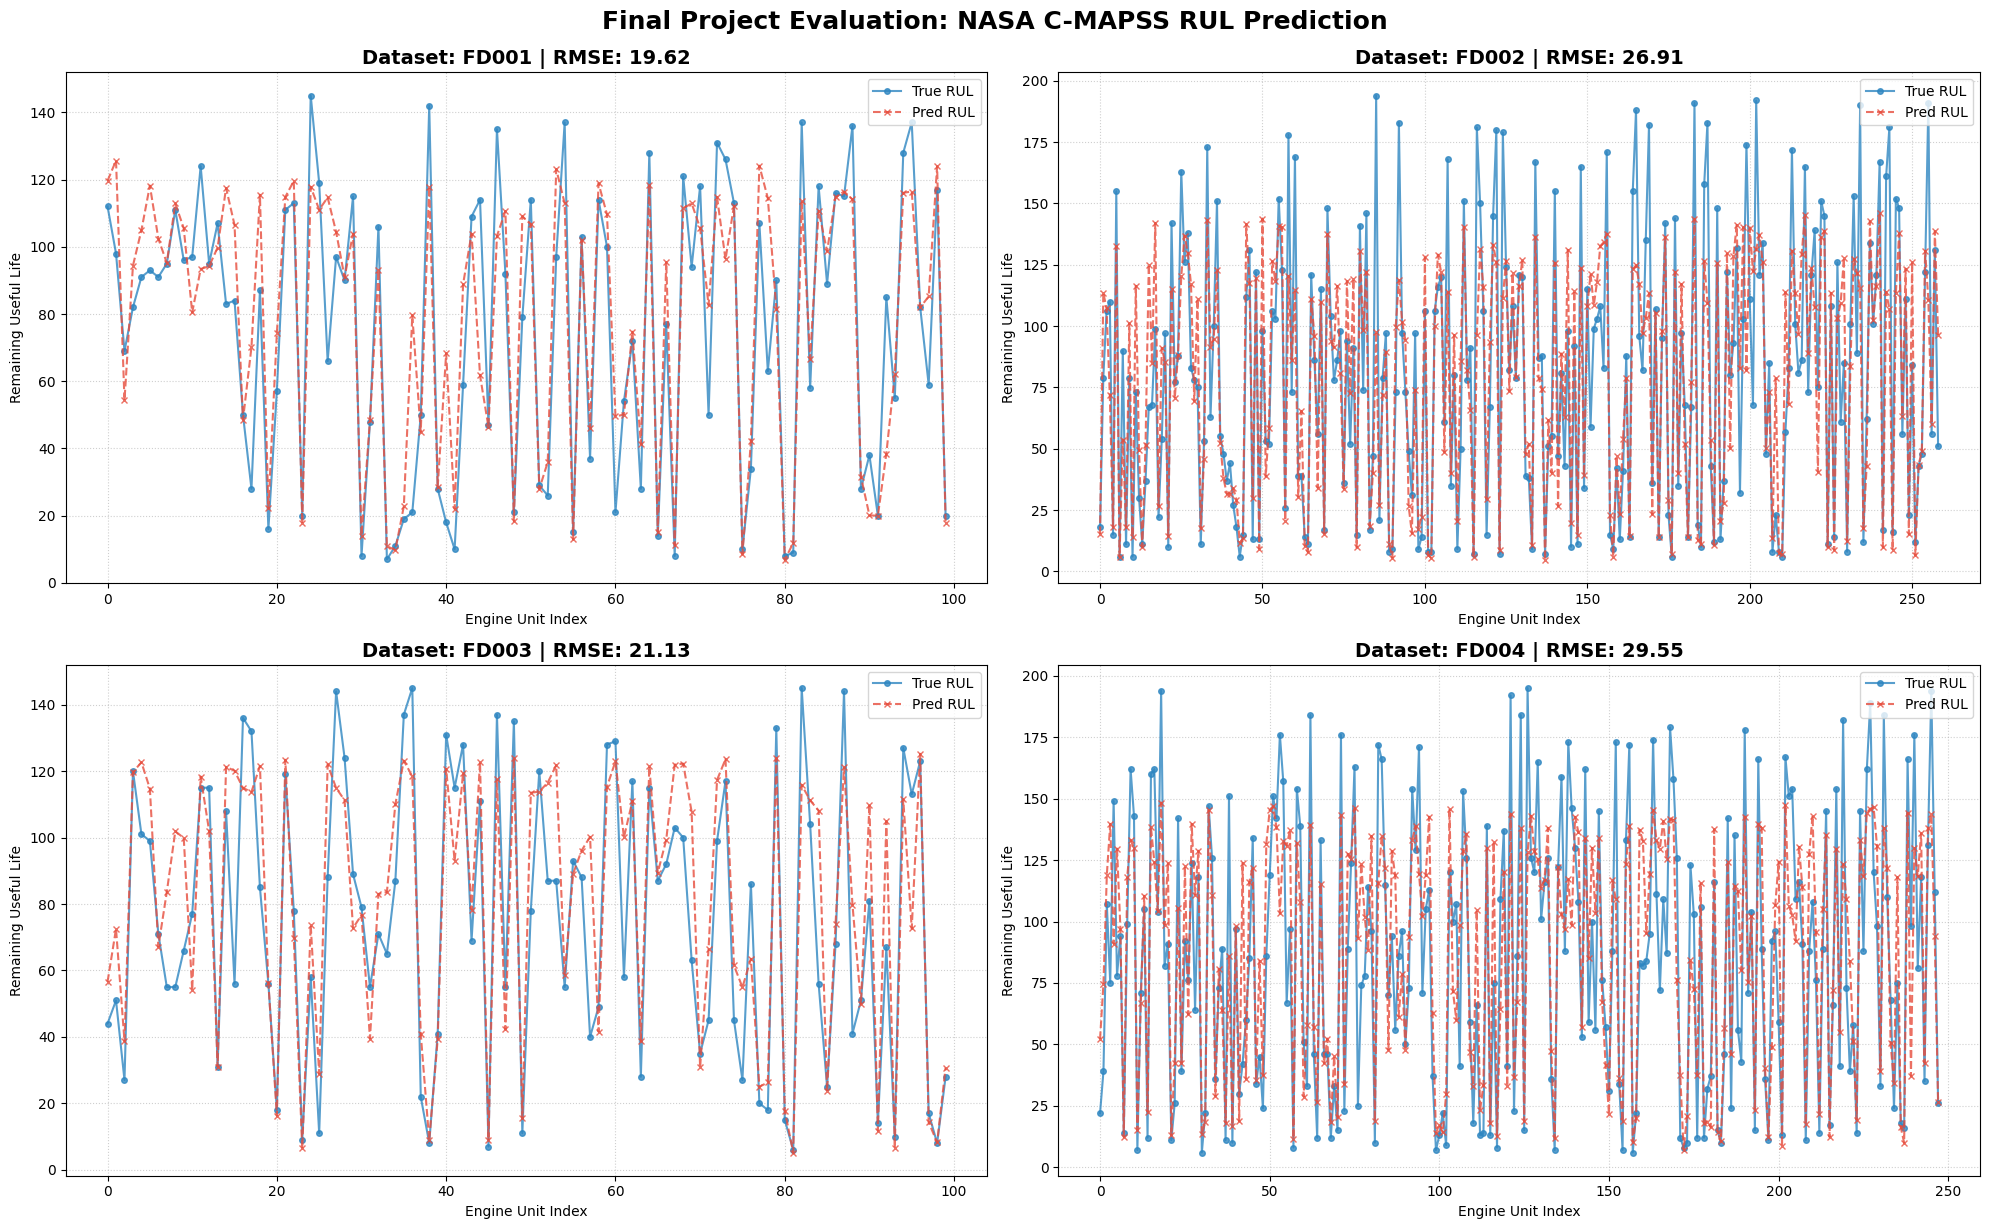

In [12]:
visualize_all_results(all_results)